In [3]:
name = 'G0.9_ssbs400_rbf_100_d6_MINEE' # filename to load/save the results
chkpt_name = name+'.pt'
fig_name = name+'.pdf'

In [4]:
import numpy as np
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact

from IPython import display

import os

%matplotlib auto

Using matplotlib backend: Qt5Agg


In [5]:
from model.minee import MINEE
from data.gaussian import Gaussian

In [6]:
np.random.seed(0)
torch.manual_seed(0)

## Data

In [7]:
sample_size = 400
rho = 0.9

In [8]:
rep = 1 # number of repeated runs
d = 6
X = np.zeros((rep,sample_size,d))
Y = np.zeros((rep,sample_size,d))
for i in range(rep):
    for j in range(d):
        data = Gaussian(sample_size=sample_size,rho=rho).data
        X[i,:,j] = data[:,0]
        Y[i,:,j] = data[:,1]

Generate the reference samples by resampling.

Text(0.5, 1.0, 'Plot of data samples')

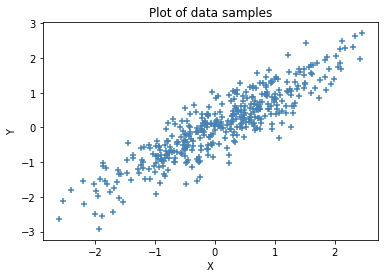

In [9]:
plt.scatter(X[0,:,0],Y[0,:,0],label="data",marker="+",color="steelblue")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of data samples')

## MI estimation

### Choice of parameters

In [10]:
batch_size = int(sample_size*1)
ref_batch_factor = 100
lr = 1e-4

### Initialization

In [11]:
minee_list = []
for i in range(rep):
    minee_list.append(MINEE(torch.Tensor(X[i]),torch.Tensor(Y[i]),batch_size=batch_size,ref_batch_factor=ref_batch_factor,lr=lr))
dXY_list = np.zeros((rep,0))
dX_list = np.zeros((rep,0))
dY_list = np.zeros((rep,0))

In [12]:
load_available = True
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    dXY_list = checkpoint['dXY_list']
    dX_list = checkpoint['dX_list']
    dY_list = checkpoint['dY_list']
    minee_state_list = checkpoint['minee_state_list']
    for i in range(rep):
        minee_list[i].load_state_dict(minee_state_list[i])

### Training

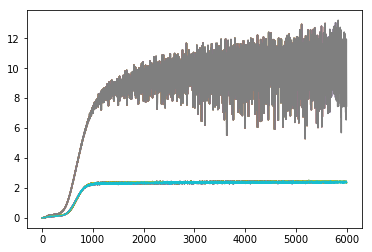

In [21]:
for k in range(10):
    for j in range(200):
        dXY_list = np.append(dXY_list, np.zeros((rep, 1)), axis=1)
        dX_list = np.append(dX_list, np.zeros((rep, 1)), axis=1)
        dY_list = np.append(dY_list, np.zeros((rep, 1)), axis=1)
        for i in range(rep):
            minee_list[i].step()
            dXY_list[i, -1], dX_list[i, -1], dY_list[i, -1] = minee_list[i].forward()
        # To show intermediate works
    for i in range(rep):
        plt.plot(dXY_list[i, :])
        plt.plot(dX_list[i, :])
        plt.plot(dY_list[i, :])
    display.clear_output(wait=True)
    display.display(plt.gcf())
display.clear_output()

In [22]:
minee_state_list = [minee_list[i].state_dict() for i in range(rep)]

In [23]:
torch.save({
    'dXY_list': dXY_list,
    'dX_list': dX_list,
    'dY_list': dY_list,
    'minee_state_list': minee_state_list
}, chkpt_name)

## Analysis

Ground truth mutual information

In [24]:
mi = - 0.5 * np.log(1-rho **2) * d
print(mi)

4.982193620464953


Apply moving average to smooth out the mutual information estimate.

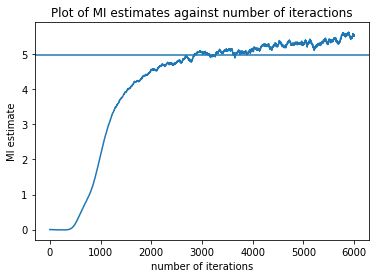

In [25]:
ma_rate = 0.01
mi_list = (dXY_list-dX_list-dY_list).copy()
for i in range(1,dXY_list.shape[1]):
    mi_list[:,i] = (1-ma_rate) * mi_list[:,i-1] + ma_rate * mi_list[:,i]
for i in range(rep):
    plt.plot(mi_list[i,:])
plt.axhline(mi)
plt.title("Plot of MI estimates against number of iteractions")
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")
plt.savefig(fig_name)